In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(-2), float(2), int(50))
# The original sin/cos data
#one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.02)

# Polynomials + diff(poly) data
one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
two = int(3)*torch.pow(train_x, int(2)) + torch.randn(train_x.size()) * float(0.2)

# Combined poly + sin/cos
#one = torch.mul(torch.sin(train_x), train_x)+ torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), train_x) + torch.sin(train_x) + torch.randn(train_x.size()) * float(0.2)

# only sin/cos
#one = torch.mul(torch.sin(train_x), torch.cos(train_x)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), torch.cos(train_x)) - torch.mul(torch.sin(train_x), torch.sin(train_x)) + torch.randn(train_x.size()) * float(0.2)


train_y = torch.stack([one, two], int(-1))


In [3]:
train_y
# = torch.Tensor([[float(-0.3), float(0.99)],[float(-0.07), float(1.01)]])

tensor([[-7.6826e+00,  1.2171e+01],
        [-7.2768e+00,  1.1169e+01],
        [-6.4987e+00,  1.0035e+01],
        [-5.4666e+00,  9.3539e+00],
        [-4.9445e+00,  8.2502e+00],
        [-4.3193e+00,  7.3933e+00],
        [-3.2975e+00,  6.5808e+00],
        [-3.1459e+00,  6.0226e+00],
        [-2.9093e+00,  5.5119e+00],
        [-2.2289e+00,  4.8903e+00],
        [-1.6082e+00,  4.3077e+00],
        [-1.6242e+00,  3.8365e+00],
        [-1.0541e+00,  3.1279e+00],
        [-7.5233e-01,  2.5077e+00],
        [-7.9122e-01,  2.1295e+00],
        [-6.6402e-01,  1.7344e+00],
        [-1.9511e-01,  1.4979e+00],
        [-2.5090e-01,  1.1463e+00],
        [ 5.4345e-02,  8.0591e-01],
        [ 5.5957e-03,  7.4494e-01],
        [ 2.2353e-02,  4.8303e-01],
        [-2.0692e-01,  1.1860e-01],
        [-5.3569e-02,  4.3218e-02],
        [ 3.1120e-02,  1.6187e-01],
        [ 1.8753e-02,  9.7350e-02],
        [ 1.0954e-01,  7.7673e-02],
        [-3.2956e-01, -3.6338e-01],
        [ 1.1853e-01,  1.381

In [4]:

len(train_y.shape)

2

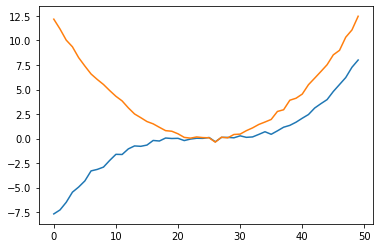

In [5]:
plt.plot(train_y)

$$
\begin{align}
L =& 
\left[
\begin{matrix}
1 & dx_1 \\
0 & 1
\end{matrix}
\right]\\
R =& 
\left[
\begin{matrix}
1 & 0\\
dx_2 & 1
\end{matrix}
\right]\\
\hat{k} =& 
\left[
\begin{matrix}
SE_1 & 0\\
0 & SE_2
\end{matrix}
\right]\\
k =& L*\hat{k}*R\\
=& \left[
\begin{matrix}
dx_1 dx_2 SE_2 + SE_1 & dx_1 SE_2\\
dx_2 SE_2 & SE_2
\end{matrix}
\right]
\end{align}
$$

In [6]:
dx1, dx2, k1, k2, f, g = var('dx1, dx2, k1, k2, f, g')
K = matrix(2,2, (k1, 0, 0, 0))
L = matrix(2, 2, (1, 0, dx1, 1))
R = matrix(2, 2, (1, dx2, 0, 1))
L*K*R
# used to see how the data should be created if I 
# decide to create it exactly as I create the kernel
#K = matrix(2,1, (f, g))
#L*L*K

[        k1     dx2*k1]
[    dx1*k1 dx1*dx2*k1]

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        kernel = Diff_SE_kernel(var=0, length=0)
        kernel2 = Diff_SE_kernel(var=0, length=0)
        q, dx1, dx2 = var('q, dx1, dx2')
        L = matrix(2, 2, (1, 0, dx1, 1))
        R = matrix(2, 2, (1, dx2, 0, 1))
        p = DiffMatrixKernel([[kernel, None], [None, None]])
        self.covar_module = p.diff(left_matrix=L, right_matrix=R)
        
        #kernel0 = gpytorch.kernels.RBFKernel()
        #kernel1 = gpytorch.kernels.RBFKernel()
        #kernel2 = gpytorch.kernels.RBFKernel()
        #kernel0 = gpytorch.kernels.PeriodicKernel()
        #kernel1 = gpytorch.kernels.PeriodicKernel()
        #kernel0 = Diff_SE_kernel(var = 0, length=0)
        #kernel1 = Diff_SE_kernel(var = 0, length=0.01)
        #kernel2 = Diff_SE_kernel(var = 0, length=0.02)
        #self.covar_module = MatrixKernel([[kernel0, kernel2], [None, kernel1]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, has_global_noise=False, has_task_noise=False)
likelihood._set_task_noises(torch.Tensor([float(0.0001),float(0.0001)]))
#likelihood._set_noise(torch.tensor(float(0.0001)))
model = MultitaskGPModel(train_x, train_y, likelihood)

List of all kernels: [Diff_SE_kernel()]
[[diffed_SE_kernel(), diffed_SE_kernel()], [diffed_SE_kernel(), diffed_SE_kernel()]]


In [ ]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(75)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

param_dict = {p[0]:[] for p in model.named_parameters() if 'covar' in p[0]}
param_dict['loss'] = []
param_dict['noise'] = []
if len(likelihood.task_noises) > 1:
    param_dict['task_noises'] = [[] for i in range(len(likelihood.task_noises))]
for p in model.named_parameters():
    if 'covar' in p[0]:
        param_dict[f"{p[0]}_grad"] = []

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    param_dict['loss'].append(loss.item())
    #pdb.set_trace()
    loss.backward()
    for parameter in model.named_parameters():
        if 'covar' in parameter[0]:
            param_dict[parameter[0]].append(parameter[1].item())
            #param_dict[f"{parameter[0]}_grad"].append(parameter[1].grad.item())
    param_dict['noise'].append(likelihood.noise.item())
    for l in range(len(likelihood.task_noises)):
        param_dict['task_noises'][l].append(likelihood.task_noises[l].item())
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

tensor([[ 1.0000e+00,  0.0000e+00,  9.9667e-01,  ..., -1.8160e-03,
          3.3546e-04, -1.3419e-03],
        [ 0.0000e+00,  1.0000e+00,  8.1361e-02,  ..., -6.6522e-03,
          1.3419e-03, -5.0319e-03],
        [ 9.9667e-01,  8.1361e-02,  1.0000e+00,  ..., -2.4403e-03,
          4.6345e-04, -1.8160e-03],
        ...,
        [-1.8160e-03, -6.6522e-03, -2.4403e-03,  ...,  1.0000e+00,
          8.1361e-02,  9.9003e-01],
        [ 3.3546e-04,  1.3419e-03,  4.6345e-04,  ...,  8.1361e-02,
          1.0000e+00,  0.0000e+00],
        [-1.3419e-03, -5.0319e-03, -1.8160e-03,  ...,  9.9003e-01,
          0.0000e+00,  1.0000e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.2969e+01,  0.0000e+00],
        [ 2.8123e+01,  0.0000e+00],
        [ 1.8031e+01,  0.0000e+00],
        [ 1.1853e+01,  0.0000e+00],
        [ 6.0685e+00,  0.0000e+00],
        [ 2.2329e+00,  0.0000e+00],
        [ 5.8205e-01,  0.0000e+00],
        [ 1.1878e-01,  0.0000e+00],
        [ 2.0032e-02,

tensor([[ 1.2203e+00,  0.0000e+00,  1.2143e+00,  ..., -8.0452e-05,
          8.5705e-06, -5.0850e-05],
        [ 0.0000e+00,  1.8101e+00,  1.4704e-01,  ..., -4.4706e-04,
          5.0850e-05, -2.8899e-04],
        [ 1.2143e+00,  1.4704e-01,  1.2203e+00,  ..., -1.2598e-04,
          1.3842e-05, -8.0452e-05],
        ...,
        [-8.0452e-05, -4.4706e-04, -1.2598e-04,  ...,  1.8101e+00,
          1.4704e-01,  1.7834e+00],
        [ 8.5705e-06,  5.0850e-05,  1.3842e-05,  ...,  1.4704e-01,
          1.2203e+00,  0.0000e+00],
        [-5.0850e-05, -2.8899e-04, -8.0452e-05,  ...,  1.7834e+00,
          0.0000e+00,  1.8101e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.0278e+01,  0.0000e+00],
        [ 3.9571e+01,  0.0000e+00],
        [ 2.7000e+01,  0.0000e+00],
        [ 2.0195e+01,  0.0000e+00],
        [ 1.3046e+01,  0.0000e+00],
        [ 7.3707e+00,  0.0000e+00],
        [ 2.8998e+00,  0.0000e+00],
        [ 8.8487e-01,  0.0000e+00],
        [ 2.2104e-01,

tensor([[ 1.4835e+00,  0.0000e+00,  1.4728e+00,  ..., -7.9788e-07,
          4.6956e-08, -4.0543e-07],
        [ 0.0000e+00,  3.2021e+00,  2.5953e-01,  ..., -6.5449e-06,
          4.0543e-07, -3.3992e-06],
        [ 1.4728e+00,  2.5953e-01,  1.4835e+00,  ..., -1.5471e-06,
          9.4335e-08, -7.9788e-07],
        ...,
        [-7.9788e-07, -6.5449e-06, -1.5471e-06,  ...,  3.2021e+00,
          2.5953e-01,  3.1335e+00],
        [ 4.6956e-08,  4.0543e-07,  9.4335e-08,  ...,  2.5953e-01,
          1.4835e+00,  0.0000e+00],
        [-4.0543e-07, -3.3992e-06, -7.9788e-07,  ...,  3.1335e+00,
          0.0000e+00,  3.2021e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.2755e+01,  0.0000e+00],
        [ 5.5136e+01,  0.0000e+00],
        [ 3.9518e+01,  0.0000e+00],
        [ 3.2613e+01,  0.0000e+00],
        [ 2.1204e+01,  0.0000e+00],
        [ 1.6744e+01,  0.0000e+00],
        [ 9.7078e+00,  0.0000e+00],
        [ 4.3829e+00,  0.0000e+00],
        [ 1.5718e+00,

tensor([[ 1.7926e+00,  0.0000e+00,  1.7745e+00,  ..., -1.4981e-09,
          4.6903e-11, -5.7143e-10],
        [ 0.0000e+00,  5.4600e+00,  4.4121e-01,  ..., -1.7497e-08,
          5.7143e-10, -6.8191e-09],
        [ 1.7745e+00,  4.4121e-01,  1.7926e+00,  ..., -3.8468e-09,
          1.2552e-10, -1.4981e-09],
        ...,
        [-1.4981e-09, -1.7497e-08, -3.8468e-09,  ...,  5.4600e+00,
          4.4121e-01,  5.2952e+00],
        [ 4.6903e-11,  5.7143e-10,  1.2552e-10,  ...,  4.4121e-01,
          1.7926e+00,  0.0000e+00],
        [-5.7143e-10, -6.8191e-09, -1.4981e-09,  ...,  5.2952e+00,
          0.0000e+00,  5.4600e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.4721e+01,  0.0000e+00],
        [ 7.4349e+01,  0.0000e+00],
        [ 5.3238e+01,  0.0000e+00],
        [ 5.3913e+01,  0.0000e+00],
        [ 3.4200e+01,  0.0000e+00],
        [ 2.7683e+01,  0.0000e+00],
        [ 1.9313e+01,  0.0000e+00],
        [ 1.3826e+01,  0.0000e+00],
        [ 6.9279e+00,

tensor([[ 2.1491e+00,  0.0000e+00,  2.1198e+00,  ..., -6.2059e-13,
          1.0131e-14, -1.6710e-13],
        [ 0.0000e+00,  8.8618e+00,  7.1354e-01,  ..., -9.8688e-12,
          1.6710e-13, -2.7143e-12],
        [ 2.1198e+00,  7.1354e-01,  2.1491e+00,  ..., -2.2414e-12,
          3.8409e-14, -6.2059e-13],
        ...,
        [-6.2059e-13, -9.8688e-12, -2.2414e-12,  ...,  8.8618e+00,
          7.1354e-01,  8.5007e+00],
        [ 1.0131e-14,  1.6710e-13,  3.8409e-14,  ...,  7.1354e-01,
          2.1491e+00,  0.0000e+00],
        [-1.6710e-13, -2.7143e-12, -6.2059e-13,  ...,  8.5007e+00,
          0.0000e+00,  8.8618e+00]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0283e+02,  0.0000e+00],
        [ 1.0052e+02,  0.0000e+00],
        [ 8.0941e+01,  0.0000e+00],
        [ 7.4221e+01,  0.0000e+00],
        [ 5.3669e+01,  0.0000e+00],
        [ 4.6358e+01,  0.0000e+00],
        [ 2.8671e+01,  0.0000e+00],
        [ 2.6119e+01,  0.0000e+00],
        [ 1.7999e+01,

tensor([[ 2.5519e+00,  0.0000e+00,  2.5072e+00,  ..., -1.1808e-16,
          1.0283e-18, -2.1777e-17],
        [ 0.0000e+00,  1.3511e+01,  1.0836e+00,  ..., -2.4195e-15,
          2.1777e-17, -4.5574e-16],
        [ 2.5072e+00,  1.0836e+00,  2.5519e+00,  ..., -6.1782e-16,
          5.6919e-18, -1.1808e-16],
        ...,
        [-1.1808e-16, -2.4195e-15, -6.1782e-16,  ...,  1.3511e+01,
          1.0836e+00,  1.2806e+01],
        [ 1.0283e-18,  2.1777e-17,  5.6919e-18,  ...,  1.0836e+00,
          2.5519e+00,  0.0000e+00],
        [-2.1777e-17, -4.5574e-16, -1.1808e-16,  ...,  1.2806e+01,
          0.0000e+00,  1.3511e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.3540e+02,  0.0000e+00],
        [ 1.3539e+02,  0.0000e+00],
        [ 1.0738e+02,  0.0000e+00],
        [ 1.0913e+02,  0.0000e+00],
        [ 7.0869e+01,  0.0000e+00],
        [ 7.7538e+01,  0.0000e+00],
        [ 4.9300e+01,  0.0000e+00],
        [ 3.8893e+01,  0.0000e+00],
        [ 2.6218e+01,

tensor([[ 2.9976e+00,  0.0000e+00,  2.9347e+00,  ..., -4.3570e-20,
          2.2285e-22, -5.6774e-21],
        [ 0.0000e+00,  1.9092e+01,  1.5258e+00,  ..., -1.0763e-18,
          5.6774e-21, -1.4322e-19],
        [ 2.9347e+00,  1.5258e+00,  2.9976e+00,  ..., -3.2034e-19,
          1.7458e-21, -4.3570e-20],
        ...,
        [-4.3570e-20, -1.0763e-18, -3.2034e-19,  ...,  1.9092e+01,
          1.5258e+00,  1.7898e+01],
        [ 2.2285e-22,  5.6774e-21,  1.7458e-21,  ...,  1.5258e+00,
          2.9976e+00,  0.0000e+00],
        [-5.6774e-21, -1.4322e-19, -4.3570e-20,  ...,  1.7898e+01,
          0.0000e+00,  1.9092e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.7216e+02,  0.0000e+00],
        [ 1.7450e+02,  0.0000e+00],
        [ 1.4668e+02,  0.0000e+00],
        [ 1.3873e+02,  0.0000e+00],
        [ 1.0908e+02,  0.0000e+00],
        [ 9.7368e+01,  0.0000e+00],
        [ 6.9657e+01,  0.0000e+00],
        [ 6.1848e+01,  0.0000e+00],
        [ 3.7946e+01,

tensor([[ 3.4816e+00,  0.0000e+00,  3.3996e+00,  ..., -1.4692e-22,
          5.2125e-25, -1.4898e-23],
        [ 0.0000e+00,  2.4876e+01,  1.9829e+00,  ..., -4.0758e-21,
          1.4898e-23, -4.2206e-22],
        [ 3.3996e+00,  1.9829e+00,  3.4816e+00,  ..., -1.3809e-21,
          5.2476e-24, -1.4692e-22],
        ...,
        [-1.4692e-22, -4.0758e-21, -1.3809e-21,  ...,  2.4876e+01,
          1.9829e+00,  2.3134e+01],
        [ 5.2125e-25,  1.4898e-23,  5.2476e-24,  ...,  1.9829e+00,
          3.4816e+00,  0.0000e+00],
        [-1.4898e-23, -4.2206e-22, -1.4692e-22,  ...,  2.3134e+01,
          0.0000e+00,  2.4876e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.1372e+02,  0.0000e+00],
        [ 2.1161e+02,  0.0000e+00],
        [ 1.8117e+02,  0.0000e+00],
        [ 1.7552e+02,  0.0000e+00],
        [ 1.3498e+02,  0.0000e+00],
        [ 1.3044e+02,  0.0000e+00],
        [ 8.5247e+01,  0.0000e+00],
        [ 8.8606e+01,  0.0000e+00],
        [ 5.5814e+01,

tensor([[ 3.9980e+00,  0.0000e+00,  3.8994e+00,  ..., -1.1625e-23,
          3.5037e-26, -1.0511e-24],
        [ 0.0000e+00,  2.9985e+01,  2.3873e+00,  ..., -3.3867e-22,
          1.0511e-24, -3.1270e-23],
        [ 3.8994e+00,  2.3873e+00,  3.9980e+00,  ..., -1.2225e-22,
          3.9558e-25, -1.1625e-23],
        ...,
        [-1.1625e-23, -3.3867e-22, -1.2225e-22,  ...,  2.9985e+01,
          2.3873e+00,  2.7783e+01],
        [ 3.5037e-26,  1.0511e-24,  3.9558e-25,  ...,  2.3873e+00,
          3.9980e+00,  0.0000e+00],
        [-1.0511e-24, -3.1270e-23, -1.1625e-23,  ...,  2.7783e+01,
          0.0000e+00,  2.9985e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.5075e+02,  0.0000e+00],
        [ 2.4922e+02,  0.0000e+00],
        [ 2.1269e+02,  0.0000e+00],
        [ 2.0954e+02,  0.0000e+00],
        [ 1.5829e+02,  0.0000e+00],
        [ 1.5905e+02,  0.0000e+00],
        [ 1.0023e+02,  0.0000e+00],
        [ 1.1048e+02,  0.0000e+00],
        [ 7.0441e+01,

tensor([[ 4.5410e+00,  0.0000e+00,  4.4303e+00,  ..., -2.6587e-23,
          8.3604e-26, -2.4770e-24],
        [ 0.0000e+00,  3.3635e+01,  2.6788e+00,  ..., -7.6486e-22,
          2.4770e-24, -7.2772e-23],
        [ 4.4303e+00,  2.6788e+00,  4.5410e+00,  ..., -2.7150e-22,
          9.1603e-25, -2.6587e-23],
        ...,
        [-2.6587e-23, -7.6486e-22, -2.7150e-22,  ...,  3.3635e+01,
          2.6788e+00,  3.1196e+01],
        [ 8.3604e-26,  2.4770e-24,  9.1603e-25,  ...,  2.6788e+00,
          4.5410e+00,  0.0000e+00],
        [-2.4770e-24, -7.2772e-23, -2.6587e-23,  ...,  3.1196e+01,
          0.0000e+00,  3.3635e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.8324e+02,  0.0000e+00],
        [ 2.8122e+02,  0.0000e+00],
        [ 2.4024e+02,  0.0000e+00],
        [ 2.3562e+02,  0.0000e+00],
        [ 1.7883e+02,  0.0000e+00],
        [ 1.7792e+02,  0.0000e+00],
        [ 1.1309e+02,  0.0000e+00],
        [ 1.2292e+02,  0.0000e+00],
        [ 7.8167e+01,

tensor([[ 5.1047e+00,  0.0000e+00,  4.9880e+00,  ..., -1.0211e-21,
          3.9879e-24, -1.1068e-22],
        [ 0.0000e+00,  3.5419e+01,  2.8253e+00,  ..., -2.7500e-20,
          1.1068e-22, -3.0443e-21],
        [ 4.9880e+00,  2.8253e+00,  5.1047e+00,  ..., -8.9899e-21,
          3.7556e-23, -1.0211e-21],
        ...,
        [-1.0211e-21, -2.7500e-20, -8.9899e-21,  ...,  3.5419e+01,
          2.8253e+00,  3.3010e+01],
        [ 3.9879e-24,  1.1068e-22,  3.7556e-23,  ...,  2.8253e+00,
          5.1047e+00,  0.0000e+00],
        [-1.1068e-22, -3.0443e-21, -1.0211e-21,  ...,  3.3010e+01,
          0.0000e+00,  3.5419e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.0924e+02,  0.0000e+00],
        [ 3.0565e+02,  0.0000e+00],
        [ 2.6187e+02,  0.0000e+00],
        [ 2.5146e+02,  0.0000e+00],
        [ 1.9521e+02,  0.0000e+00],
        [ 1.8430e+02,  0.0000e+00],
        [ 1.2331e+02,  0.0000e+00],
        [ 1.2344e+02,  0.0000e+00],
        [ 7.7009e+01,

tensor([[ 5.6851e+00,  0.0000e+00,  5.5683e+00,  ..., -2.3915e-19,
          1.3094e-21, -3.2619e-20],
        [ 0.0000e+00,  3.5406e+01,  2.8309e+00,  ..., -5.7750e-18,
          3.2619e-20, -8.0443e-19],
        [ 5.5683e+00,  2.8309e+00,  5.6851e+00,  ..., -1.6814e-18,
          9.8002e-21, -2.3915e-19],
        ...,
        [-2.3915e-19, -5.7750e-18, -1.6814e-18,  ...,  3.5406e+01,
          2.8309e+00,  3.3239e+01],
        [ 1.3094e-21,  3.2619e-20,  9.8002e-21,  ...,  2.8309e+00,
          5.6851e+00,  0.0000e+00],
        [-3.2619e-20, -8.0443e-19, -2.3915e-19,  ...,  3.3239e+01,
          0.0000e+00,  3.5406e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.2315e+02,  0.0000e+00],
        [ 3.2739e+02,  0.0000e+00],
        [ 2.7431e+02,  0.0000e+00],
        [ 2.5932e+02,  0.0000e+00],
        [ 2.0353e+02,  0.0000e+00],
        [ 1.7998e+02,  0.0000e+00],
        [ 1.3034e+02,  0.0000e+00],
        [ 1.1253e+02,  0.0000e+00],
        [ 6.9082e+01,

tensor([[ 6.2805e+00,  0.0000e+00,  6.1682e+00,  ..., -1.1925e-16,
          9.7734e-19, -2.1163e-17],
        [ 0.0000e+00,  3.3999e+01,  2.7258e+00,  ..., -2.4990e-15,
          2.1163e-17, -4.5296e-16],
        [ 6.1682e+00,  2.7258e+00,  6.2805e+00,  ..., -6.4787e-16,
          5.6219e-18, -1.1925e-16],
        ...,
        [-1.1925e-16, -2.4990e-15, -6.4787e-16,  ...,  3.3999e+01,
          2.7258e+00,  3.2186e+01],
        [ 9.7734e-19,  2.1163e-17,  5.6219e-18,  ...,  2.7258e+00,
          6.2805e+00,  0.0000e+00],
        [-2.1163e-17, -4.5296e-16, -1.1925e-16,  ...,  3.2186e+01,
          0.0000e+00,  3.3999e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.3625e+02,  0.0000e+00],
        [ 3.3708e+02,  0.0000e+00],
        [ 2.6673e+02,  0.0000e+00],
        [ 2.7354e+02,  0.0000e+00],
        [ 1.7653e+02,  0.0000e+00],
        [ 1.9599e+02,  0.0000e+00],
        [ 1.2518e+02,  0.0000e+00],
        [ 9.8554e+01,  0.0000e+00],
        [ 6.5356e+01,

tensor([[ 6.8915e+00,  0.0000e+00,  6.7868e+00,  ..., -6.0004e-14,
          7.5530e-16, -1.3879e-14],
        [ 0.0000e+00,  3.1657e+01,  2.5450e+00,  ..., -1.0647e-12,
          1.3879e-14, -2.5155e-13],
        [ 6.7868e+00,  2.5450e+00,  6.8915e+00,  ..., -2.5150e-13,
          3.3336e-15, -6.0004e-14],
        ...,
        [-6.0004e-14, -1.0647e-12, -2.5150e-13,  ...,  3.1657e+01,
          2.5450e+00,  3.0222e+01],
        [ 7.5530e-16,  1.3879e-14,  3.3336e-15,  ...,  2.5450e+00,
          6.8915e+00,  0.0000e+00],
        [-1.3879e-14, -2.5155e-13, -6.0004e-14,  ...,  3.0222e+01,
          0.0000e+00,  3.1657e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.4518e+02,  0.0000e+00],
        [ 3.3965e+02,  0.0000e+00],
        [ 2.7369e+02,  0.0000e+00],
        [ 2.6056e+02,  0.0000e+00],
        [ 1.8062e+02,  0.0000e+00],
        [ 1.7320e+02,  0.0000e+00],
        [ 1.0647e+02,  0.0000e+00],
        [ 9.1474e+01,  0.0000e+00],
        [ 6.5256e+01,

tensor([[ 7.5213e+00,  0.0000e+00,  7.4259e+00,  ..., -1.9115e-11,
          3.6924e-13, -5.6578e-12],
        [ 0.0000e+00,  2.8811e+01,  2.3221e+00,  ..., -2.8203e-10,
          5.6578e-12, -8.5277e-11],
        [ 7.4259e+00,  2.3221e+00,  7.5213e+00,  ..., -6.2925e-11,
          1.2735e-12, -1.9115e-11],
        ...,
        [-1.9115e-11, -2.8203e-10, -6.2925e-11,  ...,  2.8811e+01,
          2.3221e+00,  2.7720e+01],
        [ 3.6924e-13,  5.6578e-12,  1.2735e-12,  ...,  2.3221e+00,
          7.5213e+00,  0.0000e+00],
        [-5.6578e-12, -8.5277e-11, -1.9115e-11,  ...,  2.7720e+01,
          0.0000e+00,  2.8811e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.4069e+02,  0.0000e+00],
        [ 3.4822e+02,  0.0000e+00],
        [ 2.7096e+02,  0.0000e+00],
        [ 2.4654e+02,  0.0000e+00],
        [ 1.7924e+02,  0.0000e+00],
        [ 1.4696e+02,  0.0000e+00],
        [ 9.3781e+01,  0.0000e+00],
        [ 8.4931e+01,  0.0000e+00],
        [ 5.4888e+01,

tensor([[ 8.1778e+00,  0.0000e+00,  8.0918e+00,  ..., -2.6951e-09,
          7.7769e-11, -9.8684e-10],
        [ 0.0000e+00,  2.5943e+01,  2.0955e+00,  ..., -3.2813e-08,
          9.8684e-10, -1.2276e-08],
        [ 8.0918e+00,  2.0955e+00,  8.1778e+00,  ..., -7.2032e-09,
          2.1681e-10, -2.6951e-09],
        ...,
        [-2.6951e-09, -3.2813e-08, -7.2032e-09,  ...,  2.5943e+01,
          2.0955e+00,  2.5127e+01],
        [ 7.7769e-11,  9.8684e-10,  2.1681e-10,  ...,  2.0955e+00,
          8.1778e+00,  0.0000e+00],
        [-9.8684e-10, -1.2276e-08, -2.6951e-09,  ...,  2.5127e+01,
          0.0000e+00,  2.5943e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.4553e+02,  0.0000e+00],
        [ 3.4607e+02,  0.0000e+00],
        [ 2.4593e+02,  0.0000e+00],
        [ 2.5490e+02,  0.0000e+00],
        [ 1.6304e+02,  0.0000e+00],
        [ 1.3070e+02,  0.0000e+00],
        [ 9.0667e+01,  0.0000e+00],
        [ 6.8730e+01,  0.0000e+00],
        [ 3.5964e+01,

tensor([[ 8.8748e+00,  0.0000e+00,  8.7969e+00,  ..., -1.3710e-07,
          5.6165e-09, -5.9481e-08],
        [ 0.0000e+00,  2.3497e+01,  1.9013e+00,  ..., -1.3874e-06,
          5.9481e-08, -6.1506e-07],
        [ 8.7969e+00,  1.9013e+00,  8.8748e+00,  ..., -3.1036e-07,
          1.3216e-08, -1.3710e-07],
        ...,
        [-1.3710e-07, -1.3874e-06, -3.1036e-07,  ...,  2.3497e+01,
          1.9013e+00,  2.2880e+01],
        [ 5.6165e-09,  5.9481e-08,  1.3216e-08,  ...,  1.9013e+00,
          8.8748e+00,  0.0000e+00],
        [-5.9481e-08, -6.1506e-07, -1.3710e-07,  ...,  2.2880e+01,
          0.0000e+00,  2.3497e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.5334e+02,  0.0000e+00],
        [ 3.4373e+02,  0.0000e+00],
        [ 2.5340e+02,  0.0000e+00],
        [ 2.3460e+02,  0.0000e+00],
        [ 1.4717e+02,  0.0000e+00],
        [ 1.2246e+02,  0.0000e+00],
        [ 8.3039e+01,  0.0000e+00],
        [ 4.8459e+01,  0.0000e+00],
        [ 2.1105e+01,

tensor([[ 9.6296e+00,  0.0000e+00,  9.5576e+00,  ..., -2.6428e-06,
          1.4468e-07, -1.3031e-06],
        [ 0.0000e+00,  2.1683e+01,  1.7568e+00,  ..., -2.2643e-05,
          1.3031e-06, -1.1411e-05],
        [ 9.5576e+00,  1.7568e+00,  9.6296e+00,  ..., -5.2780e-06,
          2.9954e-07, -2.6428e-06],
        ...,
        [-2.6428e-06, -2.2643e-05, -5.2780e-06,  ...,  2.1683e+01,
          1.7568e+00,  2.1198e+01],
        [ 1.4468e-07,  1.3031e-06,  2.9954e-07,  ...,  1.7568e+00,
          9.6296e+00,  0.0000e+00],
        [-1.3031e-06, -1.1411e-05, -2.6428e-06,  ...,  2.1198e+01,
          0.0000e+00,  2.1683e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.6317e+02,  0.0000e+00],
        [ 3.4773e+02,  0.0000e+00],
        [ 2.6082e+02,  0.0000e+00],
        [ 2.1956e+02,  0.0000e+00],
        [ 1.4140e+02,  0.0000e+00],
        [ 1.1406e+02,  0.0000e+00],
        [ 6.8815e+01,  0.0000e+00],
        [ 3.2613e+01,  0.0000e+00],
        [ 1.2173e+01,

tensor([[ 1.0465e+01,  0.0000e+00,  1.0396e+01,  ..., -1.9106e-05,
          1.2893e-06, -1.0256e-05],
        [ 0.0000e+00,  2.0811e+01,  1.6877e+00,  ..., -1.4400e-04,
          1.0256e-05, -7.9021e-05],
        [ 1.0396e+01,  1.6877e+00,  1.0465e+01,  ..., -3.5108e-05,
          2.4519e-06, -1.9106e-05],
        ...,
        [-1.9106e-05, -1.4400e-04, -3.5108e-05,  ...,  2.0811e+01,
          1.6877e+00,  2.0400e+01],
        [ 1.2893e-06,  1.0256e-05,  2.4519e-06,  ...,  1.6877e+00,
          1.0465e+01,  0.0000e+00],
        [-1.0256e-05, -7.9021e-05, -1.9106e-05,  ...,  2.0400e+01,
          0.0000e+00,  2.0811e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.6281e+02,  0.0000e+00],
        [ 3.7788e+02,  0.0000e+00],
        [ 2.6895e+02,  0.0000e+00],
        [ 2.1509e+02,  0.0000e+00],
        [ 1.4204e+02,  0.0000e+00],
        [ 1.0623e+02,  0.0000e+00],
        [ 5.6734e+01,  0.0000e+00],
        [ 2.3416e+01,  0.0000e+00],
        [ 7.7682e+00,

tensor([[ 1.1403e+01,  0.0000e+00,  1.1333e+01,  ..., -5.6403e-05,
          4.2813e-06, -3.1672e-05],
        [ 0.0000e+00,  2.1089e+01,  1.7110e+00,  ..., -3.9434e-04,
          3.1672e-05, -2.2637e-04],
        [ 1.1333e+01,  1.7110e+00,  1.1403e+01,  ..., -9.9173e-05,
          7.7834e-06, -5.6403e-05],
        ...,
        [-5.6403e-05, -3.9434e-04, -9.9173e-05,  ...,  2.1089e+01,
          1.7110e+00,  2.0701e+01],
        [ 4.2813e-06,  3.1672e-05,  7.7834e-06,  ...,  1.7110e+00,
          1.1403e+01,  0.0000e+00],
        [-3.1672e-05, -2.2637e-04, -5.6403e-05,  ...,  2.0701e+01,
          0.0000e+00,  2.1089e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 3.8837e+02,  0.0000e+00],
        [ 4.0113e+02,  0.0000e+00],
        [ 2.8296e+02,  0.0000e+00],
        [ 2.2159e+02,  0.0000e+00],
        [ 1.4744e+02,  0.0000e+00],
        [ 1.0386e+02,  0.0000e+00],
        [ 5.1444e+01,  0.0000e+00],
        [ 1.9670e+01,  0.0000e+00],
        [ 6.0878e+00,

tensor([[ 1.2458e+01,  0.0000e+00,  1.2383e+01,  ..., -8.2916e-05,
          6.5261e-06, -4.7190e-05],
        [ 0.0000e+00,  2.2521e+01,  1.8274e+00,  ..., -5.6617e-04,
          4.7190e-05, -3.2944e-04],
        [ 1.2383e+01,  1.8274e+00,  1.2458e+01,  ..., -1.4388e-04,
          1.1706e-05, -8.2916e-05],
        ...,
        [-8.2916e-05, -5.6617e-04, -1.4388e-04,  ...,  2.2521e+01,
          1.8274e+00,  2.2116e+01],
        [ 6.5261e-06,  4.7190e-05,  1.1706e-05,  ...,  1.8274e+00,
          1.2458e+01,  0.0000e+00],
        [-4.7190e-05, -3.2944e-04, -8.2916e-05,  ...,  2.2116e+01,
          0.0000e+00,  2.2521e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.2228e+02,  0.0000e+00],
        [ 4.3460e+02,  0.0000e+00],
        [ 3.0560e+02,  0.0000e+00],
        [ 2.3799e+02,  0.0000e+00],
        [ 1.5847e+02,  0.0000e+00],
        [ 1.0936e+02,  0.0000e+00],
        [ 5.2896e+01,  0.0000e+00],
        [ 1.9753e+01,  0.0000e+00],
        [ 5.9812e+00,

tensor([[ 1.3630e+01,  0.0000e+00,  1.3546e+01,  ..., -7.0880e-05,
          5.4130e-06, -3.9891e-05],
        [ 0.0000e+00,  2.5111e+01,  2.0373e+00,  ..., -4.9360e-04,
          3.9891e-05, -2.8400e-04],
        [ 1.3546e+01,  2.0373e+00,  1.3630e+01,  ..., -1.2435e-04,
          9.8184e-06, -7.0880e-05],
        ...,
        [-7.0880e-05, -4.9360e-04, -1.2435e-04,  ...,  2.5111e+01,
          2.0373e+00,  2.4651e+01],
        [ 5.4130e-06,  3.9891e-05,  9.8184e-06,  ...,  2.0373e+00,
          1.3630e+01,  0.0000e+00],
        [-3.9891e-05, -2.8400e-04, -7.0880e-05,  ...,  2.4651e+01,
          0.0000e+00,  2.5111e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 4.6381e+02,  0.0000e+00],
        [ 4.7879e+02,  0.0000e+00],
        [ 3.3756e+02,  0.0000e+00],
        [ 2.6410e+02,  0.0000e+00],
        [ 1.7576e+02,  0.0000e+00],
        [ 1.2339e+02,  0.0000e+00],
        [ 6.0875e+01,  0.0000e+00],
        [ 2.3184e+01,  0.0000e+00],
        [ 7.1492e+00,

tensor([[ 1.4908e+01,  0.0000e+00,  1.4812e+01,  ..., -4.0717e-05,
          2.8795e-06, -2.2258e-05],
        [ 0.0000e+00,  2.8809e+01,  2.3367e+00,  ..., -2.9793e-04,
          2.2258e-05, -1.6649e-04],
        [ 1.4812e+01,  2.3367e+00,  1.4908e+01,  ..., -7.3501e-05,
          5.3773e-06, -4.0717e-05],
        ...,
        [-4.0717e-05, -2.9793e-04, -7.3501e-05,  ...,  2.8809e+01,
          2.3367e+00,  2.8255e+01],
        [ 2.8795e-06,  2.2258e-05,  5.3773e-06,  ...,  2.3367e+00,
          1.4908e+01,  0.0000e+00],
        [-2.2258e-05, -1.6649e-04, -4.0717e-05,  ...,  2.8255e+01,
          0.0000e+00,  2.8809e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.1296e+02,  0.0000e+00],
        [ 5.3281e+02,  0.0000e+00],
        [ 3.7798e+02,  0.0000e+00],
        [ 2.9959e+02,  0.0000e+00],
        [ 1.9860e+02,  0.0000e+00],
        [ 1.4523e+02,  0.0000e+00],
        [ 7.5299e+01,  0.0000e+00],
        [ 3.0147e+01,  0.0000e+00],
        [ 9.7313e+00,

tensor([[ 1.6266e+01,  0.0000e+00,  1.6156e+01,  ..., -2.0315e-05,
          1.3128e-06, -1.0720e-05],
        [ 0.0000e+00,  3.3208e+01,  2.6925e+00,  ..., -1.5733e-04,
          1.0720e-05, -8.4865e-05],
        [ 1.6156e+01,  2.6925e+00,  1.6266e+01,  ..., -3.7960e-05,
          2.5395e-06, -2.0315e-05],
        ...,
        [-2.0315e-05, -1.5733e-04, -3.7960e-05,  ...,  3.3208e+01,
          2.6925e+00,  3.2534e+01],
        [ 1.3128e-06,  1.0720e-05,  2.5395e-06,  ...,  2.6925e+00,
          1.6266e+01,  0.0000e+00],
        [-1.0720e-05, -8.4865e-05, -2.0315e-05,  ...,  3.2534e+01,
          0.0000e+00,  3.3208e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.6818e+02,  0.0000e+00],
        [ 5.9286e+02,  0.0000e+00],
        [ 4.2308e+02,  0.0000e+00],
        [ 3.4144e+02,  0.0000e+00],
        [ 2.2450e+02,  0.0000e+00],
        [ 1.7114e+02,  0.0000e+00],
        [ 9.3880e+01,  0.0000e+00],
        [ 3.9857e+01,  0.0000e+00],
        [ 1.3557e+01,

tensor([[ 1.7671e+01,  0.0000e+00,  1.7547e+01,  ..., -1.2446e-05,
          7.5442e-07, -6.4010e-06],
        [ 0.0000e+00,  3.7484e+01,  3.0383e+00,  ..., -1.0027e-04,
          6.4010e-06, -5.2709e-05],
        [ 1.7547e+01,  3.0383e+00,  1.7671e+01,  ..., -2.3849e-05,
          1.4974e-06, -1.2446e-05],
        ...,
        [-1.2446e-05, -1.0027e-04, -2.3849e-05,  ...,  3.7484e+01,
          3.0383e+00,  3.6694e+01],
        [ 7.5442e-07,  6.4010e-06,  1.4974e-06,  ...,  3.0383e+00,
          1.7671e+01,  0.0000e+00],
        [-6.4010e-06, -5.2709e-05, -1.2446e-05,  ...,  3.6694e+01,
          0.0000e+00,  3.7484e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.2473e+02,  0.0000e+00],
        [ 6.5281e+02,  0.0000e+00],
        [ 4.6734e+02,  0.0000e+00],
        [ 3.8281e+02,  0.0000e+00],
        [ 2.4983e+02,  0.0000e+00],
        [ 1.9527e+02,  0.0000e+00],
        [ 1.1130e+02,  0.0000e+00],
        [ 4.9277e+01,  0.0000e+00],
        [ 1.7381e+01,

tensor([[ 1.9095e+01,  0.0000e+00,  1.8960e+01,  ..., -1.1857e-05,
          7.0886e-07, -6.0639e-06],
        [ 0.0000e+00,  4.0838e+01,  3.3100e+00,  ..., -9.6337e-05,
          6.0639e-06, -5.0358e-05],
        [ 1.8960e+01,  3.3100e+00,  1.9095e+01,  ..., -2.2847e-05,
          1.4150e-06, -1.1857e-05],
        ...,
        [-1.1857e-05, -9.6337e-05, -2.2847e-05,  ...,  4.0838e+01,
          3.3100e+00,  3.9970e+01],
        [ 7.0886e-07,  6.0639e-06,  1.4150e-06,  ...,  3.3100e+00,
          1.9095e+01,  0.0000e+00],
        [-6.0639e-06, -5.0358e-05, -1.1857e-05,  ...,  3.9970e+01,
          0.0000e+00,  4.0838e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.7692e+02,  0.0000e+00],
        [ 7.0744e+02,  0.0000e+00],
        [ 5.0674e+02,  0.0000e+00],
        [ 4.1652e+02,  0.0000e+00],
        [ 2.7135e+02,  0.0000e+00],
        [ 2.1314e+02,  0.0000e+00],
        [ 1.2246e+02,  0.0000e+00],
        [ 5.4718e+01,  0.0000e+00],
        [ 1.9451e+01,

tensor([[ 2.0520e+01,  0.0000e+00,  2.0378e+01,  ..., -1.8253e-05,
          1.1354e-06, -9.4864e-06],
        [ 0.0000e+00,  4.2861e+01,  3.4746e+00,  ..., -1.4473e-04,
          9.4864e-06, -7.6887e-05],
        [ 2.0378e+01,  3.4746e+00,  2.0520e+01,  ..., -3.4620e-05,
          2.2302e-06, -1.8253e-05],
        ...,
        [-1.8253e-05, -1.4473e-04, -3.4620e-05,  ...,  4.2861e+01,
          3.4746e+00,  4.1972e+01],
        [ 1.1354e-06,  9.4864e-06,  2.2302e-06,  ...,  3.4746e+00,
          2.0520e+01,  0.0000e+00],
        [-9.4864e-06, -7.6887e-05, -1.8253e-05,  ...,  4.1972e+01,
          0.0000e+00,  4.2861e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.2183e+02,  0.0000e+00],
        [ 7.5396e+02,  0.0000e+00],
        [ 5.3913e+02,  0.0000e+00],
        [ 4.3887e+02,  0.0000e+00],
        [ 2.8731e+02,  0.0000e+00],
        [ 2.2242e+02,  0.0000e+00],
        [ 1.2485e+02,  0.0000e+00],
        [ 5.4342e+01,  0.0000e+00],
        [ 1.8890e+01,

tensor([[ 2.1940e+01,  0.0000e+00,  2.1795e+01,  ..., -4.0032e-05,
          2.7013e-06, -2.1489e-05],
        [ 0.0000e+00,  4.3633e+01,  3.5383e+00,  ..., -3.0174e-04,
          2.1489e-05, -1.6557e-04],
        [ 2.1795e+01,  3.5383e+00,  2.1940e+01,  ..., -7.3562e-05,
          5.1371e-06, -4.0032e-05],
        ...,
        [-4.0032e-05, -3.0174e-04, -7.3562e-05,  ...,  4.3633e+01,
          3.5383e+00,  4.2770e+01],
        [ 2.7013e-06,  2.1489e-05,  5.1371e-06,  ...,  3.5383e+00,
          2.1940e+01,  0.0000e+00],
        [-2.1489e-05, -1.6557e-04, -4.0032e-05,  ...,  4.2770e+01,
          0.0000e+00,  4.3633e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.6063e+02,  0.0000e+00],
        [ 7.9224e+02,  0.0000e+00],
        [ 5.6387e+02,  0.0000e+00],
        [ 4.5095e+02,  0.0000e+00],
        [ 2.9780e+02,  0.0000e+00],
        [ 2.2273e+02,  0.0000e+00],
        [ 1.1895e+02,  0.0000e+00],
        [ 4.9098e+01,  0.0000e+00],
        [ 1.6289e+01,

In [ ]:
param_dict

In [ ]:
for parameter in model.named_parameters():
    print(parameter)

In [ ]:
for param_key in param_dict:
    if param_key == 'task_noises':
        pass
    else:
        plt.plot(param_dict[param_key], label=param_key)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


In [ ]:
print(likelihood.noise)
print(likelihood.task_noises)

In [ ]:
A = matrix(QQ, 4, 4, (2,0,0.6065,0.6065,0,1,-0.6065,0.6065,0.6065,-0.6065,2,0,0.6065,0.6065,0,1))
L = A.cholesky()
L*L.transpose()

In [ ]:
for parameter in model.named_parameters():
    print(parameter)

In [ ]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(120)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(-2), float(7), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


In [ ]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(4)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-30, 30])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-30, 30])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


In [ ]:
a = matrix(1, 2, (1, 2))
b = matrix(2, 2, (1, 2, 3, 4))
a*b

# Test Diffable SE Kernel

In [ ]:
X = torch.tensor([int(1), int(2), int(3)])
X

In [ ]:
X = torch.linspace(float(-2), float(2), int(4))

In [ ]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = float(SE.diff(x2).diff(x1)(int(v1), int(v2), lengthscale, variance))
cov_matr

In [ ]:
print(SE.diff(x1))
print(SE.diff(x1).diff(x2))
float(SE.diff(x2).diff(x1)(float(1.), float(1.), 1, 1))

In [ ]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1 
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
left_poly = dx2
right_poly = 1
diffed_kernel2 = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate() + diffed_kernel2(X).evaluate()

In [ ]:
def calc_cell_diff(L, M, R, context=None):
    len_M = np.shape(M)[0]
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
       map(list, itertools.zip_longest(*M, fillvalue=None)))
    for r_elem, row_M in zip(R, M_transpose):
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                if m_elem is not None:
                    temp = l_elem * m_elem*r_elem
                    #temp = l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
            else:
                if m_elem is not None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                    temp += l_elem * m_elem*r_elem
                    #temp += l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
    return temp.simplify_full()


In [ ]:
dimension = 3
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 0
col = 0
for row in range(dimension):
    for col in range(dimension):
        print((L*M*R)[row][col])
print("\n\n")
for i, (l, r) in enumerate(itertools.product(L.rows(), R.columns())):

    print(calc_cell_diff(l, M, r))
    print("\n")

In [ ]:
def calc_cell_diff_sage(L, M, R, context=None):
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
        map(list, itertools.zip_longest(*M, fillvalue=None)))
    # Every row in 'M' is combined with each elem of the row given in 'R'
    # Or: For each elemtn in row 'R' combine with 'row_M'
    for r_elem, row_M in zip(R, M_transpose):
        # Each element in L gets exactly one element in 'row_M' to multiply
        # Or: Combine each element in row_M with exactly one element in 'L'
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp = m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp = m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp = m_elem.diff(l_elem)
                else:
                    pass
            else:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp += m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp += m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp += m_elem.diff(l_elem)
                    
                else:
                    pass
    return temp

def diff_sage(matrix, left_matrix=None, right_matrix=None):
    # iterate left matrix by rows and right matrix by columns and call the
    # respective diff command of the kernels with the row/cols as params
    kernel = MatrixKernel(None)
    output_matrix = [[0 for i in range(np.shape(matrix)[1])] for j in range(np.shape(matrix)[0])]
    for i, (l, r) in enumerate(itertools.product(left_matrix.rows(), right_matrix.columns())):
        res = calc_cell_diff_sage(l, matrix, r, context=kernel)
        output_matrix[int(i/np.shape(matrix)[0])][
                    int(i % np.shape(matrix)[0])]  = res
    kernel.set_matrix(output_matrix)
    return output_matrix


In [ ]:
import pprint
L = matrix(2, 2, (x1, x1, 0, x1))
R = matrix(2, 2, (x2, 0, x2, x2))
x1, x2, l, sigma, l2, sigma2 = var('x1, x2, l, sigma, l2, sigma2')
lengthscale = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance = 1
lengthscale2 = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance2 = 1
SEKernelMatrix = [[sigma^2*exp(-(x1-x2)^2/(2*l^2)), sigma2^2*exp(-(x1-x2)^2/(2*l2^2))], [sigma2^2*exp(-(x1-x2)^2/(2*l2^2)), sigma^2*exp(-(x1-x2)^2/(2*l^2))]]
#diffed_SE_sage_matrix_kernel = diff_sage(SEKernelMatrix, left_matrix=L, right_matrix=R)
#pprint.pprint(diffed_SE_sage_matrix_kernel)
cov_matr = [[None for i in range(len(X)*len(SEKernelMatrix))] for j in range(len(X)*len(SEKernelMatrix))]
for i, (v1, v2) in enumerate(product(X, X)):
    for row in range(len(SEKernelMatrix)):
        for col in range(len(SEKernelMatrix)):
            # Blockwise
            #cov_matr[int(i/len(X))+row*len(X)][int(i%len(X))+col*len(X)] = SEKernelMatrix[row][col].substitute(x1=int(v1), x2=int(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2)
            # Interleaved
            text=f"x-pos: {int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row}" +\
            f" y-pos: {int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))}" + \
            f" x1, x2: {v1}, {v2}\n" +\
            f"(x1-x2)^2: {(v1-v2)**2}"+\
            f" exp((x1-x2)^2): {np.exp((v1-v2)**2)}\n"+\
            f"val: {float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))}"
            print(text)
            print("---")
            cov_matr[int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row][int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))] = float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))
cov_matr


In [ ]:
print(X)
print(torch.Tensor(cov_matr).eig())

In [ ]:
exp(-(-2-0.66)^2/(2))

In [ ]:

kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (dx1, dx1, 0, dx1))
R = matrix(2, 2, (dx2, 0, dx2, dx2))

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
covar_module = p.diff(left_matrix=L, right_matrix=R)

covar_x = covar_module(X)
covar_x.evaluate()

In [ ]:
matr = [[2, 0, -6*e^(-2), 1, e^(-1/2), -e^(-2)],
 [0, 2, 0, -e^(-1/2), 1, e^(-1/2)],
 [-6*e^(-2), 0, 2, -5*e^(-2), -e^(-1/2), 1],
 [1, e^(-1/2), -e^(-2), 1, 0, -3*e^(-2)],
 [-e^(-1/2), 1, e^(-1/2), 0, 1, 0],
 [-5*e^(-2), -e^(-1/2), 1, -3*e^(-2), 0, 1]]

matr = [[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

matr = torch.Tensor(matr)
import pprint
pprint.pprint(matr)
print(matr[0::3, 0::3])
H_x = 3
torch.vstack([torch.hstack([matr[k::H_x, l::H_x] for l in range(H_x)]) for k in range(H_x)])

In [ ]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [ ]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

In [ ]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [ ]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

In [ ]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

In [ ]:
prod([1,2,3])

In [ ]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

In [ ]:
a, b, c, d = var('a, b, c, d')
A = matrix(2,2, (a, b, c, d))
B = matrix(2, 2, (dx1, dx1, 0, dx1))
C = matrix(2, 2, (dx2, 0, dx2, dx2))
print(A)
print(B)
B*A

In [ ]:
x = ['a', 'b', 'c']
y = x                 # x and y reference the same object
z = ['a', 'b', 'c']   # x and z reference different objects
#z


print(x is z)
z = x
print(x is z)
